# Goal

* Map incorporators on the phylogeny

# Setting variables

In [1]:
%load_ext rpy2.ipython

In [8]:
%%R


# Note that Nick has separate phyloseq objects for sip and the bulk soil saved
physeqDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/'

physeqFull = 'Full-Sparsity3in3'
#physeqBulk = 'bulk-core' 


nprocs = 20

workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
figDir = '/home/bryan/RhizCG/figures/rhizosphere_enriched'

RhizEnrichedFile = file.path(workDir, 'bare-plant.csv')

biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'
biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [3]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(foreach)
library(doParallel)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.

# Loading files

In [12]:
%%R 
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
physeq.Full = readRDS(F)
physeq.Full.m = physeq.Full %>% sample_data
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [14]:
%%R 

physeq.bare = subset_samples(physeq.Full, Plant == "BARE")
physeq.bare.m = physeq.bare %>% sample_data
physeq.bare

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [15]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(RhizEnrichedFile, sep=',')
df.l2fc %>% head(n=3)

  log2FoldChange         p    Rank1         Rank2      Rank3
1     -1.2362293 0.9508456 Bacteria Acidobacteria      32-21
2     -0.9586041 0.9990821 Bacteria Acidobacteria Holophagae
3      1.2753701 0.1881231 Bacteria Acidobacteria Holophagae
                 Rank4                Rank5 Rank6 Rank7 Rank8      OTU Day
1 uncultured_bacterium                 <NA>  <NA>  <NA>  <NA> OTU.5899  36
2              Sva0725                 <NA>  <NA>  <NA>  <NA> OTU.8680  36
3              Sva0725 uncultured_bacterium  <NA>  <NA>  <NA> OTU.2666  36
  Plant     p.adj
1 FAGES 1.0000000
2 FAGES 1.0000000
3 FAGES 0.8652547


## Making tree plot & metadata plots separately, then combining with grid.arrange

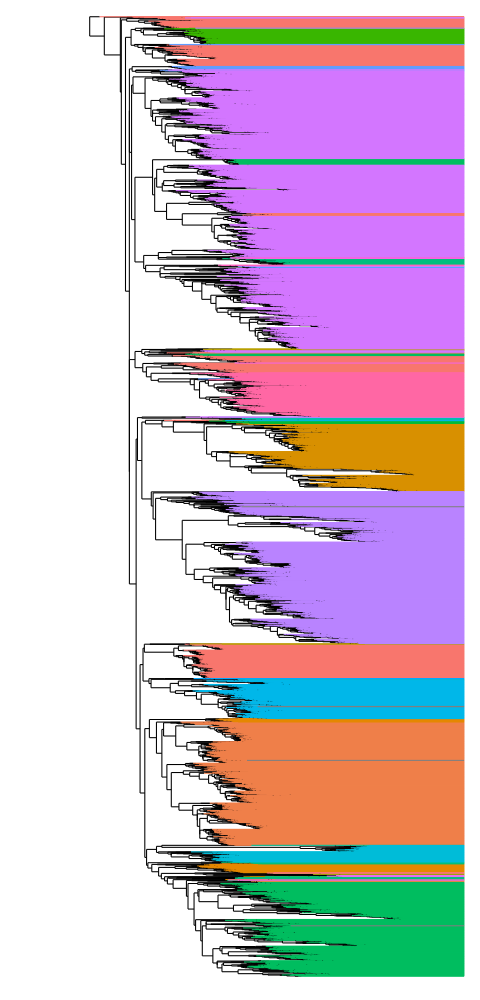

In [17]:
%%R -h 1000

plot_tree = function(physeq, color.rank="Rank2", legend.title='Phylum', 
                     plot.margin=NULL, y.expand=c(0.01,0.01),
                     legend.position='none', legend.size=4){
    # general tree plotting with ggplot
    as.Num = function(x){ x %>% as.character %>% as.numeric }
    
    # plot margin
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }

    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_inner = treeSegs$edgeDT[is.na(treeSegs$edgeDT$OTU)]
    edge_otu = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)]

    # adding taxonomy to left edges
    physeq.tax = physeq %>% tax_table %>% as.matrix %>% as.data.frame %>%
        mutate(OTU = rownames(.))
    edge_otu.df = edge_otu %>% as.matrix %>% as.data.frame %>%
        mutate(xleft = xleft %>% as.Num,
               xright = xright %>% as.Num,
               y = y %>% as.Num)
    edge_otu.df = inner_join(edge_otu.df, physeq.tax, c('OTU' = 'OTU')) %>%
        mutate(Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3),
               Rank4 = gsub('^__', '', Rank4),
               Rank5 = gsub('^__', '', Rank5),
               Rank6 = gsub('^__', '', Rank6),
               Rank7 = gsub('^__', '', Rank7),
               Rank8 = gsub('^__', '', Rank8)) 
    
    # adding node-metadata connector lines
    edge_otu.con = edge_otu.df %>%
                     mutate(max.xright = max(xright, na.rm=T),
                            xleft = xright,
                            xright = max.xright)
    
    # dummy facet
    edge_inner$FACET = 1
    
    # making tree plot
    p.tree = ggplot(data=edge_inner) + 
        geom_segment(aes(x=xleft, xend=xright, y=y, yend=y)) + 
        geom_segment(data=edge_otu.df, 
                     aes(x=xleft, xend=xright, y=y, yend=y)) +
        geom_segment(data=edge_otu.con,
                     aes_string(x="xleft", xend="xright", y="y", 
                                yend="y", color=color.rank)) + 
        geom_segment(data=treeSegs$vertDT, 
                     aes(x=x, xend=x, y=vmin, yend=vmax)) +
        scale_y_continuous(expand=y.expand) +
        scale_color_discrete(legend.title) +
        facet_grid(. ~ FACET) +
        theme_bw() +
        guides(colour = guide_legend(override.aes = list(size=legend.size))) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = legend.position,
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            plot.margin = plot.margin
            )
    return(p.tree)
    }

#-- test --#
p.tree = plot_tree(physeq.Full, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'))
p.tree

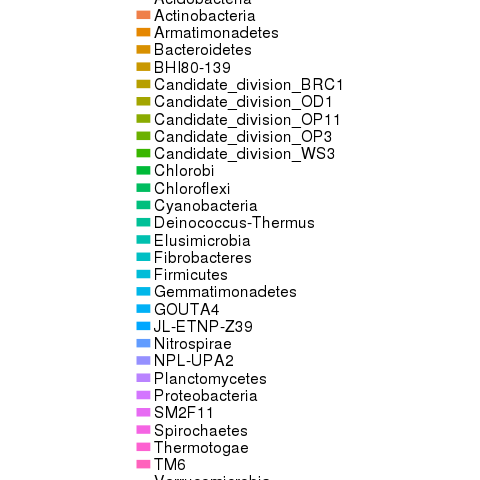

In [18]:
%%R

g_legend = function(a.gplot, text.size = 20, legend.position=c(0.5, 0.5)){ 
    # function for plotting just legend
    a.gplot = a.gplot + theme(legend.position=legend.position, 
                              text = element_text(size=text.size))
    tmp = ggplot_gtable(ggplot_build(a.gplot)) 
    leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend = tmp$grobs[[leg]] 
    return(legend)
    } 
                        
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [19]:
%%R 

as.Num = function(x){ x %>% as.character %>% as.numeric }

order_metadata_to_tree = function(physeq, metadata){
    # function for parsing & giving y (y.tree) value to metadata
        
    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_otu.df = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)] %>%
                as.matrix %>% 
                as.data.frame %>%
                mutate(y.tree = y %>% as.Num) %>%
                select(OTU, y.tree)
    
    # joining leaf edge and metadata
    inner_join(edge_otu.df, metadata, c('OTU' = 'OTU'))     
    }

#-- test --#
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 
df.l2fc.ord %>% head(n=4)

       OTU y.tree log2FoldChange         p Day Plant p.adj
1 OTU.5899   4982     -1.2362293 0.9508456  36 FAGES     1
2 OTU.5899   4982     -0.6887040 0.7714534  53 AMAPO     1
3 OTU.5899   4982      0.4218789 0.5191518  53 ECHCG     1
4 OTU.5899   4982     -0.5051195 0.7572744  57 ABUTH     1


In [28]:
%%R 

# calc wUnifrac distance
calc.wunif.dist = function(physeq, cores=8){
    registerDoParallel(cores=cores)
    wunif.dist = distance(physeq,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(wunif.dist)
    }


# ordering substrates by w-unifrac distances between plants
order_plants_by_responders = function(metadata, physeq, p.adj.cutoff=0.05, ...){
   
    # filtering physeq to just incorporators
    responders = metadata %>%
        filter(p.adj < p.adj.cutoff)
    taxa.names = taxa_names(physeq)
    taxa.to.rm = taxa.names[taxa.names %in% responders$OTU]
    physeq.cut = prune_taxa(taxa.to.rm, physeq)
    
    # merging samples by Plant
    physeq.cut.merge = merge_samples(physeq.cut, "Plant")
    
    # removing 12C-con
    physeq.md = physeq.cut.merge %>% sample_data
    physeq.md$Plant = rownames(physeq.md)
    sample_data(physeq.cut.merge) = physeq.md
    physeq.cut.merge = prune_samples(physeq.md$Plant != 'BARE', physeq.cut.merge)
        
    # w-unifrac
    wunif.dist = calc.wunif.dist(physeq.cut.merge, ...)
        
    # hclust of w-unifrac values
    wunif.clust = hclust(wunif.dist, method='average')
    
    # ordering metadata by hclust ordering
    Plants = metadata$Plant %>% as.vector %>% unique
    Plants = Plants[wunif.clust$order]
    metadata$Plant = factor(metadata$Plant, levels=Plants)
    
    return(metadata)
}

#-- test --#
#calc.wunif.dist(physeq.thresh, cores=20)
df.l2fc.ord2 = order_plants_by_responders(df.l2fc.ord, physeq.Full, cores=nprocs)
df.l2fc.ord2 %>% head(n=4)

       OTU y.tree log2FoldChange         p Day Plant p.adj
1 OTU.5899   4982     -1.2362293 0.9508456  36 FAGES     1
2 OTU.5899   4982     -0.6887040 0.7714534  53 AMAPO     1
3 OTU.5899   4982      0.4218789 0.5191518  53 ECHCG     1
4 OTU.5899   4982     -0.5051195 0.7572744  57 ABUTH     1


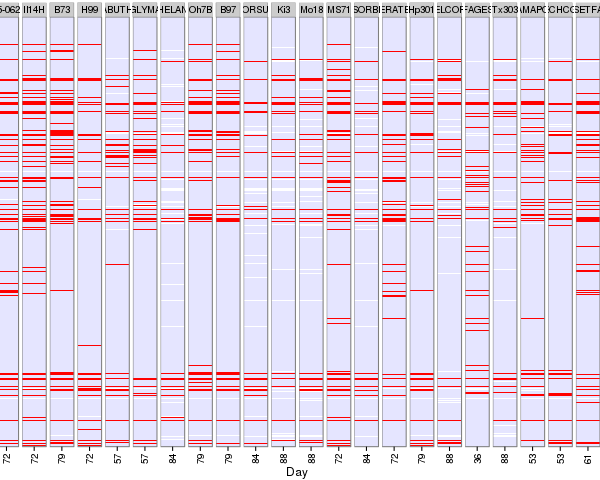

In [31]:
%%R -w 600

# function for making incorporator plot
responders_plot = function(metadata, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,-0.7), "cm")  # top, right, bottom, left        
    }
    
    metadata.ord = metadata %>%
        mutate(responder = p.adj < 0.05,
               responder.num = responder %>% as.numeric,
               Day = Day %>% as.character)
    
    metadata.ord$Day = reorder(metadata.ord$Day, metadata.ord$Day %>% as.numeric)

    min.y = metadata.ord$y.tree %>% min(na.rm=T)
    max.y = metadata.ord$y.tree %>% max(na.rm=T)    
    
    p.responder = ggplot(metadata.ord, aes(Day, y.tree, fill=responder, alpha=responder.num)) +
        geom_tile() +
        scale_fill_manual(values=c('blue', 'red')) +
        scale_y_continuous(expand=c(0,0)) +
        facet_grid(. ~ Plant, scales='free_x') +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            )   
    return(p.responder)
    }

#-- test --#
p.responders = responders_plot(df.l2fc.ord2)
p.responders

### Making OTU bulk soil abundance plots

In [45]:
%%R

bulk_abund_plot_df = function(physeq, l2fc.ord){
    # creating a df for making bulk soil abundance plots
    # physeq = physeq ob bulk soil samples
    physeq.m = physeq %>% sample_data
    physeq.f = prune_samples(physeq.m$Plant == 'BARE', physeq)
    physeq.f.m = physeq.f %>% sample_data %>% as.data.frame
    
    ## OTU table
    tbl.otu = physeq.f %>% otu_table %>% as.data.frame
    tbl.otu$OTU = rownames(tbl.otu)
    n.col = ncol(tbl.otu)
    tbl.otu = gather(tbl.otu, 'sample', 'count', 1:(n.col-1)) %>%
        group_by(OTU) %>%
        mutate(count_byOTU_norm = count / sum(count) * 100) %>%          
        group_by(sample) %>%
        mutate(count_byComm_norm = count / sum(count) * 100) %>%
        ungroup
    
    ## joining with metadata & filtering
    df.bulk = inner_join(tbl.otu, physeq.f.m, c('sample' = 'X.sample')) 
    
    ## adding tree location info
    l2fc.ord.d = l2fc.ord %>%
        select(OTU, y.tree) %>%
        distinct()
    df.bulk.j = left_join(l2fc.ord.d,  df.bulk, c('OTU' = 'OTU')) %>%
        mutate(Day = DAP %>% as.character,
               DAP = ifelse(is.na(DAP), 1, DAP),
               count = ifelse(is.na(count), 0, count),
               count_byOTU_norm = ifelse(is.na(count_byOTU_norm), 0, count_byOTU_norm),
               count_byComm_norm = ifelse(is.na(count_byComm_norm), 0, count_byComm_norm)) 
    
    return(df.bulk.j)
    }

df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord2) 
df.bulk %>% head(n=3)

       OTU y.tree            sample count count_byOTU_norm count_byComm_norm
1 OTU.5899   4982 sample2-1.06_Npos     0         0.000000      0.0000000000
2 OTU.5899   4982 sample6-4.27_Npos     1         1.694915      0.0009065854
3 OTU.5899   4982 sample4-4.27_Nneg     0         0.000000      0.0000000000
  Library Primer_Plate Primer_Well_ID primerFR_ID_byPlate primerFR_ID_total
1       1            1             H9                  72                72
2       1            2            F11                  86               182
3       1            1            B12                  90                90
  barcode_ID    PlotID Plant Plot Treatment Rep DAP Sampling  PlantSample Type
1         72 1.06_Npos  BARE 1.06      Npos   1  53  sample2 BARE_sample2 BARE
2        182 4.27_Npos  BARE 4.27      Npos   4  79  sample6 BARE_sample6 BARE
3         90 4.27_Nneg  BARE 4.27      Nneg   4  61  sample4 BARE_sample4 BARE
  Grass_Broad    Status Subfamily fwd_barcode rev_barcode Planted Biomas

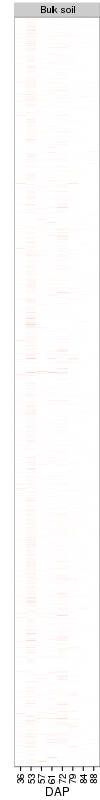

In [46]:
%%R -w 100 -h 800
    
bulk_rel_abund_plot = function(df, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,0), "cm")  # top, right, bottom, left        
    }
    
    df$DAP = reorder(df$DAP, df$DAP %>% as.numeric)
    df$Bulk = 'Bulk soil'   
    
    p.abund = ggplot(df, aes(DAP, y.tree, fill=count_byOTU_norm)) +
        geom_tile(stat='identity') +
        scale_fill_continuous(low='#FFFFFF', high='#990000',na.value='grey80') +
        scale_y_continuous(expand=c(0,0)) +
        facet_grid(. ~ Bulk) +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            ) 
    return(p.abund)
    }

p.rel.abund = bulk_rel_abund_plot(df.bulk)
p.rel.abund

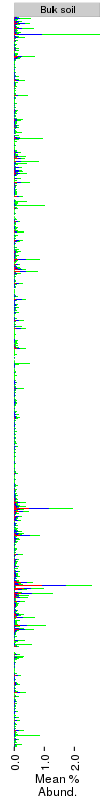

In [48]:
%%R -w 100 -h 800

bulk_rel_total_abund_plot = function(df, 
                                     plot.margin=NULL, bar.width=3, 
                                     #total.counts=NULL, 
                                     round.digits=0,
                                     scale.y.log10=FALSE){
    # function for plotting abundances of taxa relative to whole community
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,0), "cm")  # top, right, bottom, left        
    }

    
    # summing counts
    df.s = df %>%
           group_by(OTU, y.tree) %>%  
           summarize(min_count_byComm_norm = min(count_byComm_norm),
                mean_count_byComm_norm = mean(count_byComm_norm),
                max_count_byComm_norm = max(count_byComm_norm)) %>% 
           ungroup()

    df.s$Bulk = 'Bulk soil'
    
    # digit formating
    print.f = paste(c('%.', round.digits, 'f'), collapse='')
    
    # plotting
    p.abund = ggplot(df.s, aes(y.tree)) +
        geom_bar(aes(y=max_count_byComm_norm), stat='identity', width=bar.width, fill='green') + 
        geom_bar(aes(y=mean_count_byComm_norm), stat='identity', width=bar.width, fill='blue') +
        geom_bar(aes(y=min_count_byComm_norm), stat='identity', width=bar.width, fill='red') +
        scale_x_continuous(expand=c(0,0)) +
        facet_grid(. ~ Bulk) +    
        coord_flip() +
        theme_bw() +
        labs(y='Mean %\nAbund.') +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title.x = element_text(size=12),
            axis.text.x = element_text(size=12, angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            panel.border = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            ) 
    if(scale.y.log10){
        p.abund = p.abund + 
            scale_y_log10(expand=c(0,0)) 
    } else {
        p.abund = p.abund +
            scale_y_continuous(expand=c(0,0), label=function(x) sprintf(print.f, round(x, round.digits))) 
    }
    return(p.abund)
    }

#-- test --#
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 

                           
total_counts = df.bulk %>% 
    group_by(Day) %>%
    summarize(total_count = sum(count)) %>%
    as.data.frame      
                           
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, 
                                              round.digits=1) 
p.rel.total.abund

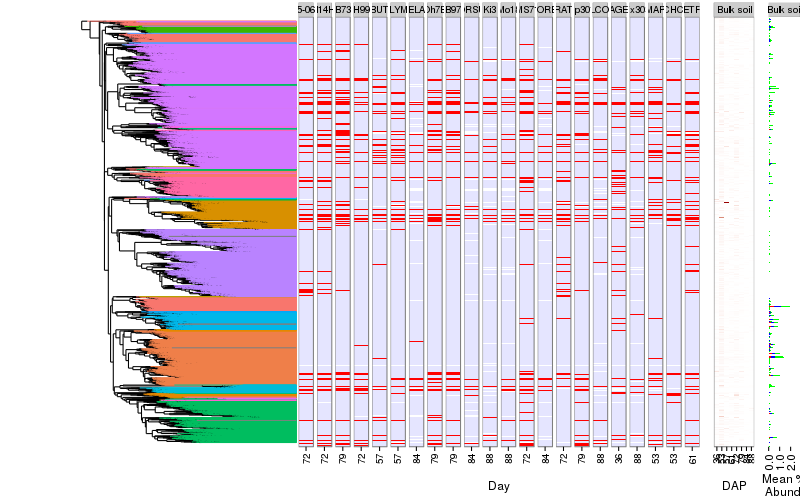

In [50]:
%%R -w 800 -h 500
    
resize_ggplots = function(ggplot.list,
                          resize.index = length(ggplot.list),
                          widths=rep(1, length(ggplot.list))){
    # other.plots = list of plots
    stopifnot(class(ggplot.list)[1] == 'list')
    
    ## making gtables
    make_gt = function(x) ggplot_gtable(ggplot_build(x))
    gt = lapply(ggplot.list, make_gt)
        
    # resizing
    gt.len = length(gt)    
    for(i in 1:gt.len){
        if(i == resize.index){
            next
        } else {
            gt[[i]]$heights = gt[[resize.index]]$heights
        }
    }
        
    # grid.arrange params
    params.l = list('ncol' = gt.len, 'widths' = widths)

    # return list of gtables + params
    return(c(gt, params.l))
    } 

x = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund), 
                   widths=c(1,1.3,0.18,0.15))
do.call(grid.arrange, x)

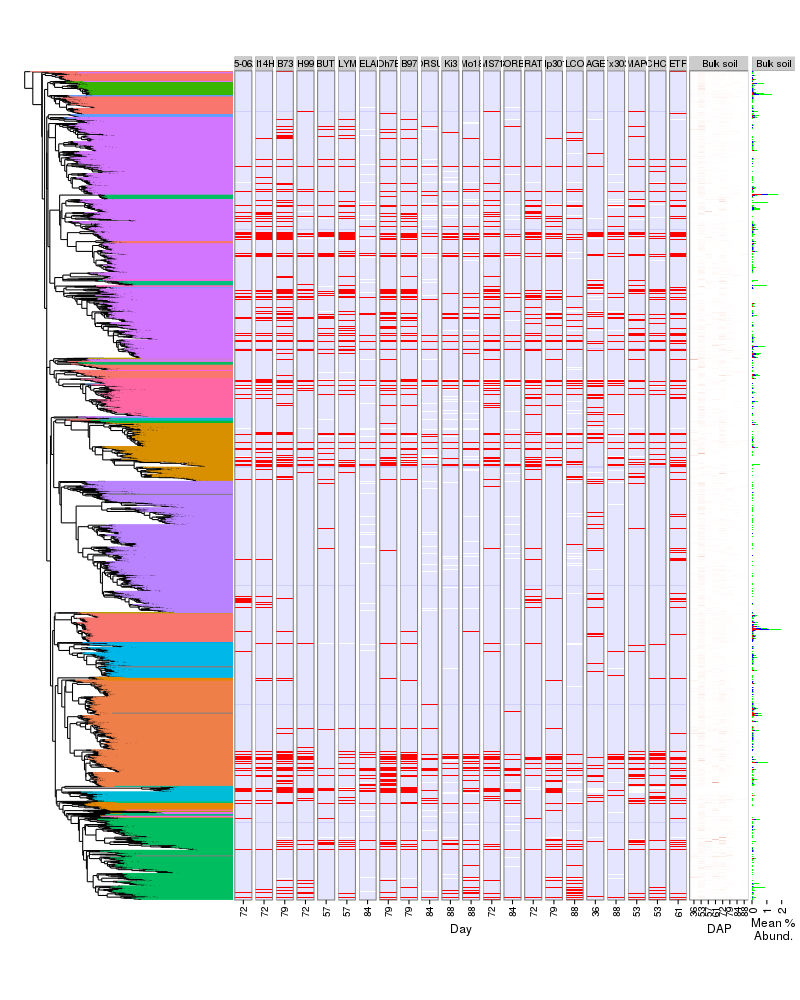

In [56]:
%%R -w 800 -h 1000
# tree plot
p.tree = plot_tree(physeq.Full, 
                   legend.title=' Phylum', 
                   y.expand=c(0.001,0.001),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_plants_by_responders(df.l2fc.ord, physeq.Full, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

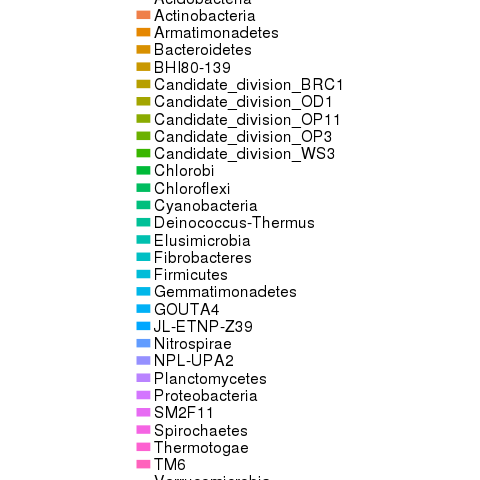

In [57]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

## full tree; just incorporators

In [59]:
%%R
# adding incorporator status to tax_table
p.adj.cutoff = 0.05

physeq.Full.resp = physeq.Full
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) %>%
    group_by(OTU) %>%
    summarize(Responder = any(p.adj < p.adj.cutoff) %>% as.numeric) %>%
    ungroup() 

tax = physeq.Full.resp %>% tax_table %>% as.data.frame
tax$OTU = rownames(tax)
tax.j = left_join(tax, df.l2fc.s, c('OTU' = 'OTU')) %>% 
    mutate(Responder = ifelse(is.na(Responder), 0, Responder)) %>%
    as.data.frame() 
rownames(tax.j) = tax.j$OTU %>% as.character
tax.j$OTU = NULL

# making new phyloseq object with incorporator info
physeq.Full.resp = phyloseq(physeq.Full.resp %>% otu_table, 
                             tax.j %>% as.matrix %>% tax_table, 
                             physeq.Full.resp %>% sample_data,
                             physeq.Full.resp %>% phy_tree)
physeq.Full.resp = subset_taxa(physeq.Full.resp, Responder==1)
physeq.Full.resp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


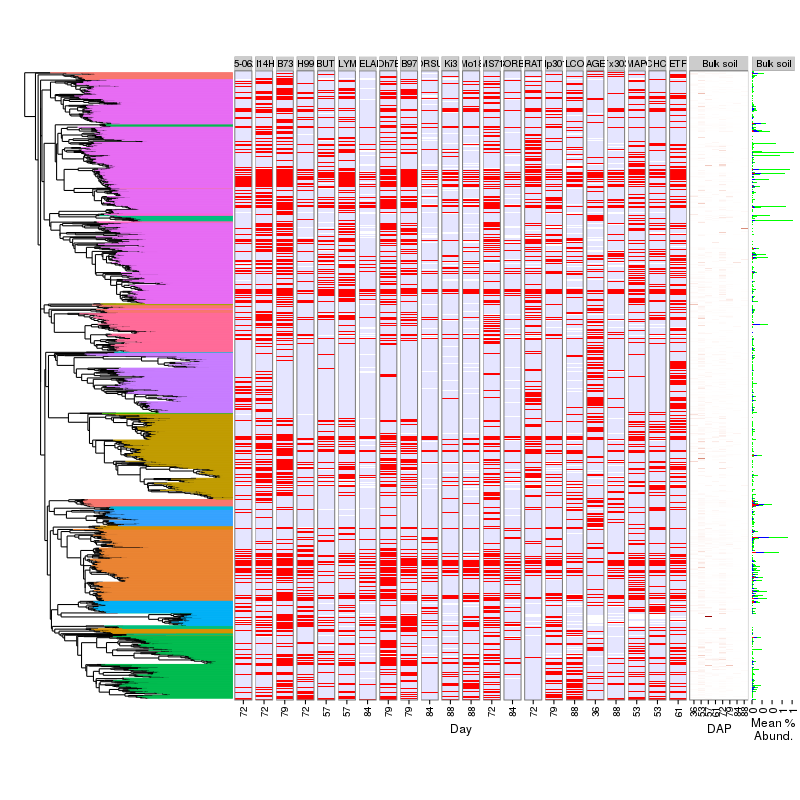

In [63]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of responders
df.l2fc.ord = order_plants_by_responders(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1.25, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

### Simple plot: not bulk abundance data

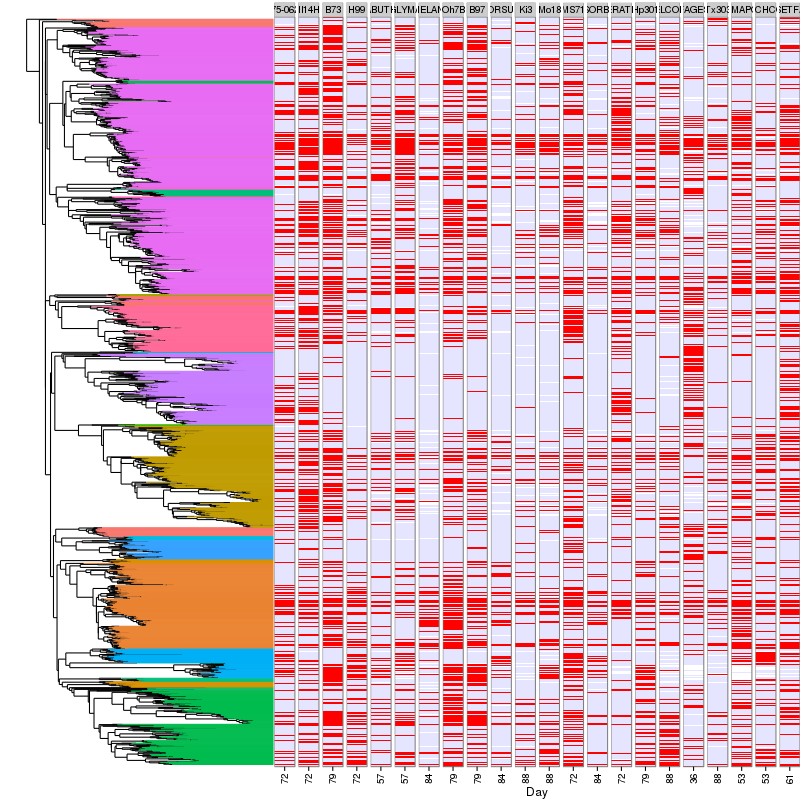

In [67]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.2,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_plants_by_responders(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.3))
do.call(grid.arrange, gt)

In [207]:
%%R
# saving figure
outFile = 'allPhyla-inc_sparCut0.3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [208]:
%%R 
# saving legend
outFile = 'allPhyla-inc_sparCut0.3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


# Figures for each phylum

In [209]:
%%R
# ordering substrates by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Substrate %>% levels
full.tree.ord

[1] "13C-Van" "13C-Cel" "13C-Pal" "13C-Oxa" "13C-Lac" "13C-Glu" "13C-Xyl"
[8] "13C-Ami" "13C-Gly"


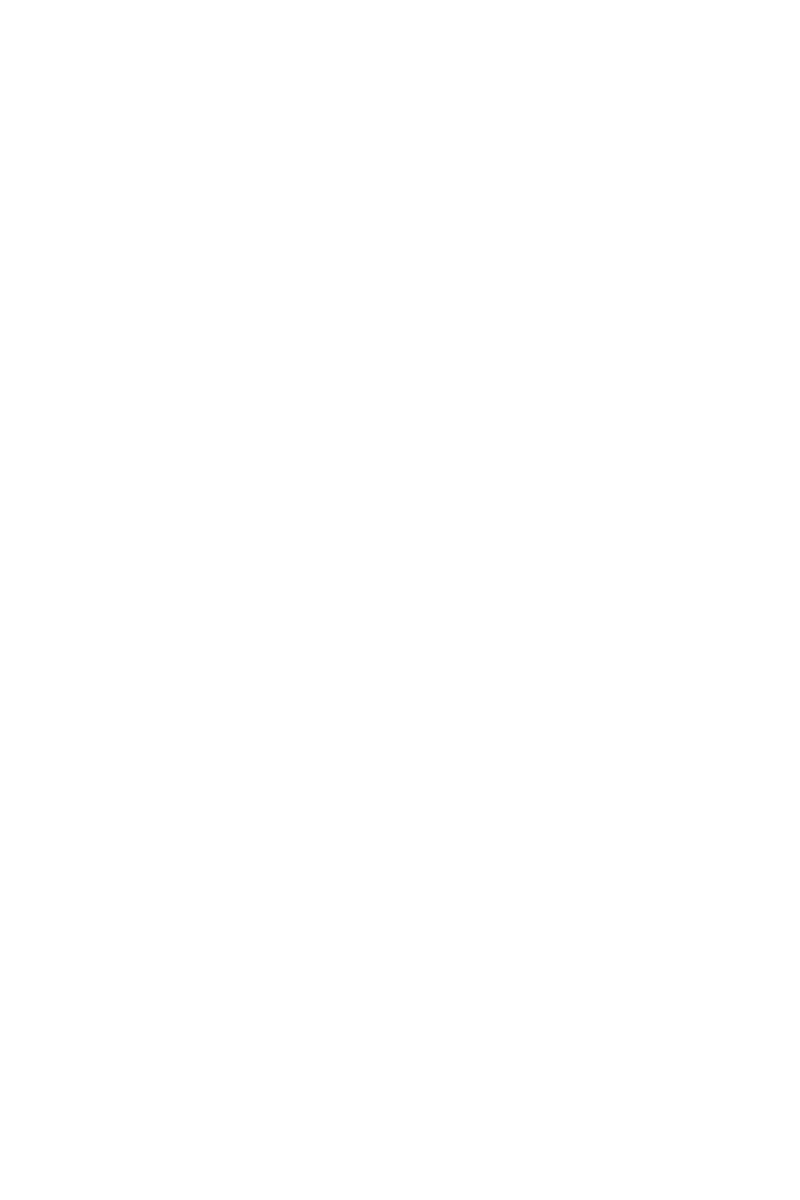

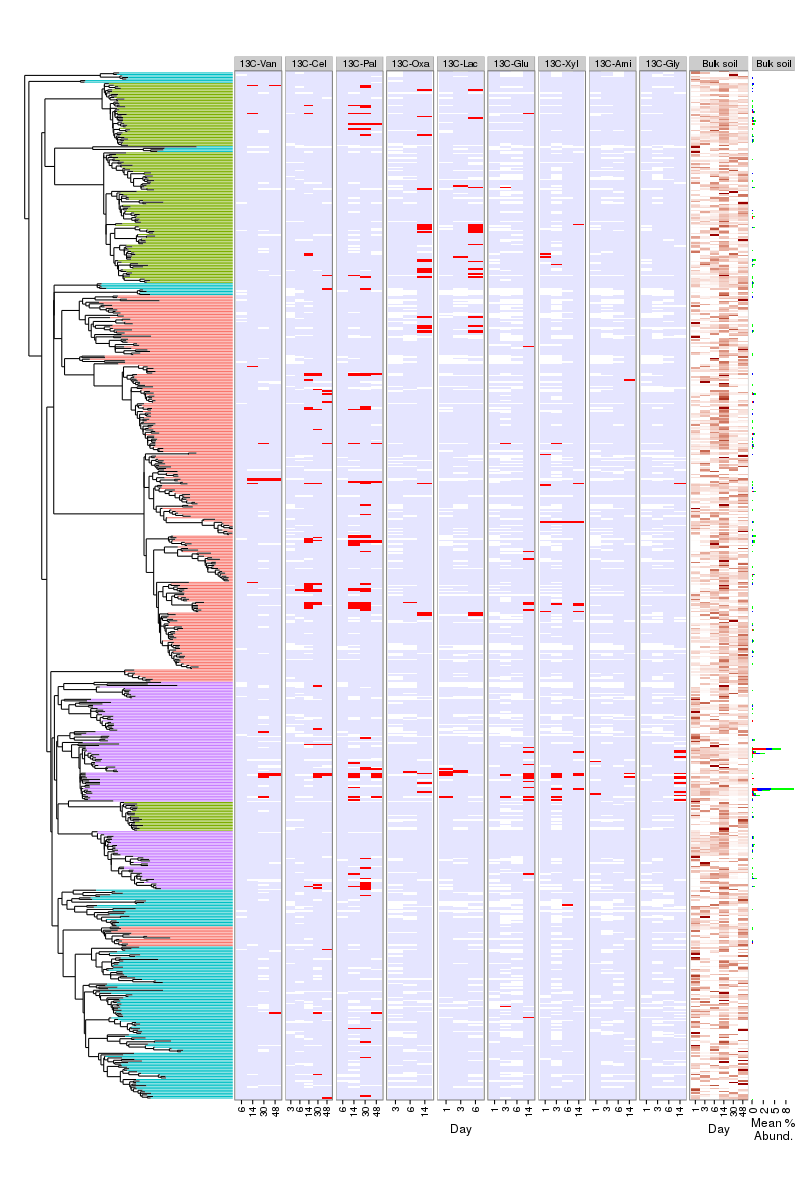

In [217]:
%%R -w 800 -h 1200

# phylum selection
phylum = "__Proteobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

# ~ old ~

## Full tree

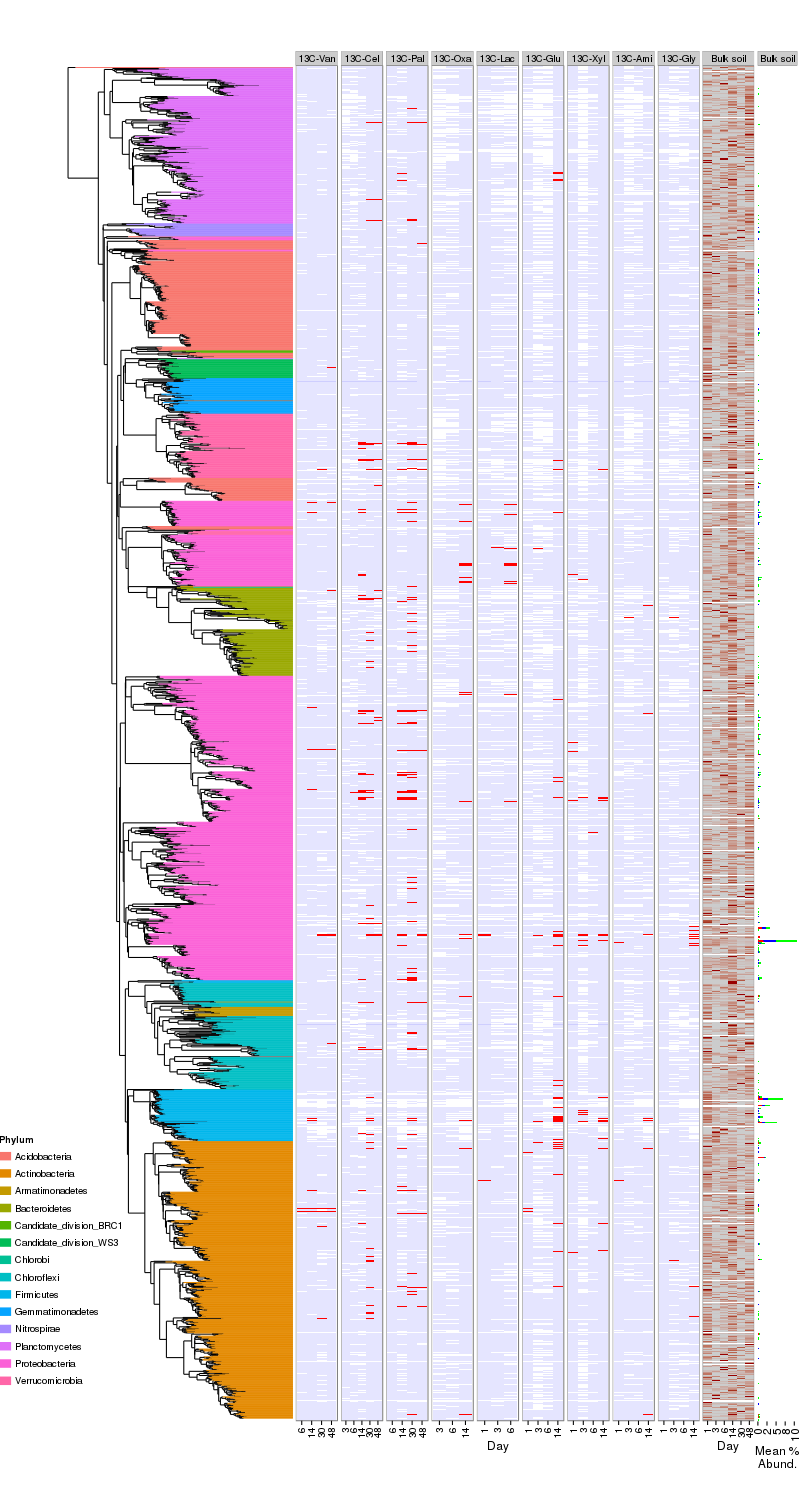

In [288]:
%%R -w 800 -h 1500
# tree plot
p.tree = plot_tree(physeq.thresh, legend.title=' Phylum', 
                   legend.position=c(0.01,0.15), 
                   plot.margin=unit(c(0,0,0,1.5), "cm"))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.thresh, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.thresh, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.81,0,1.62,-0.8), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.81,0,1.62,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, plot.margin=unit(c(1.81,0.1,1,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

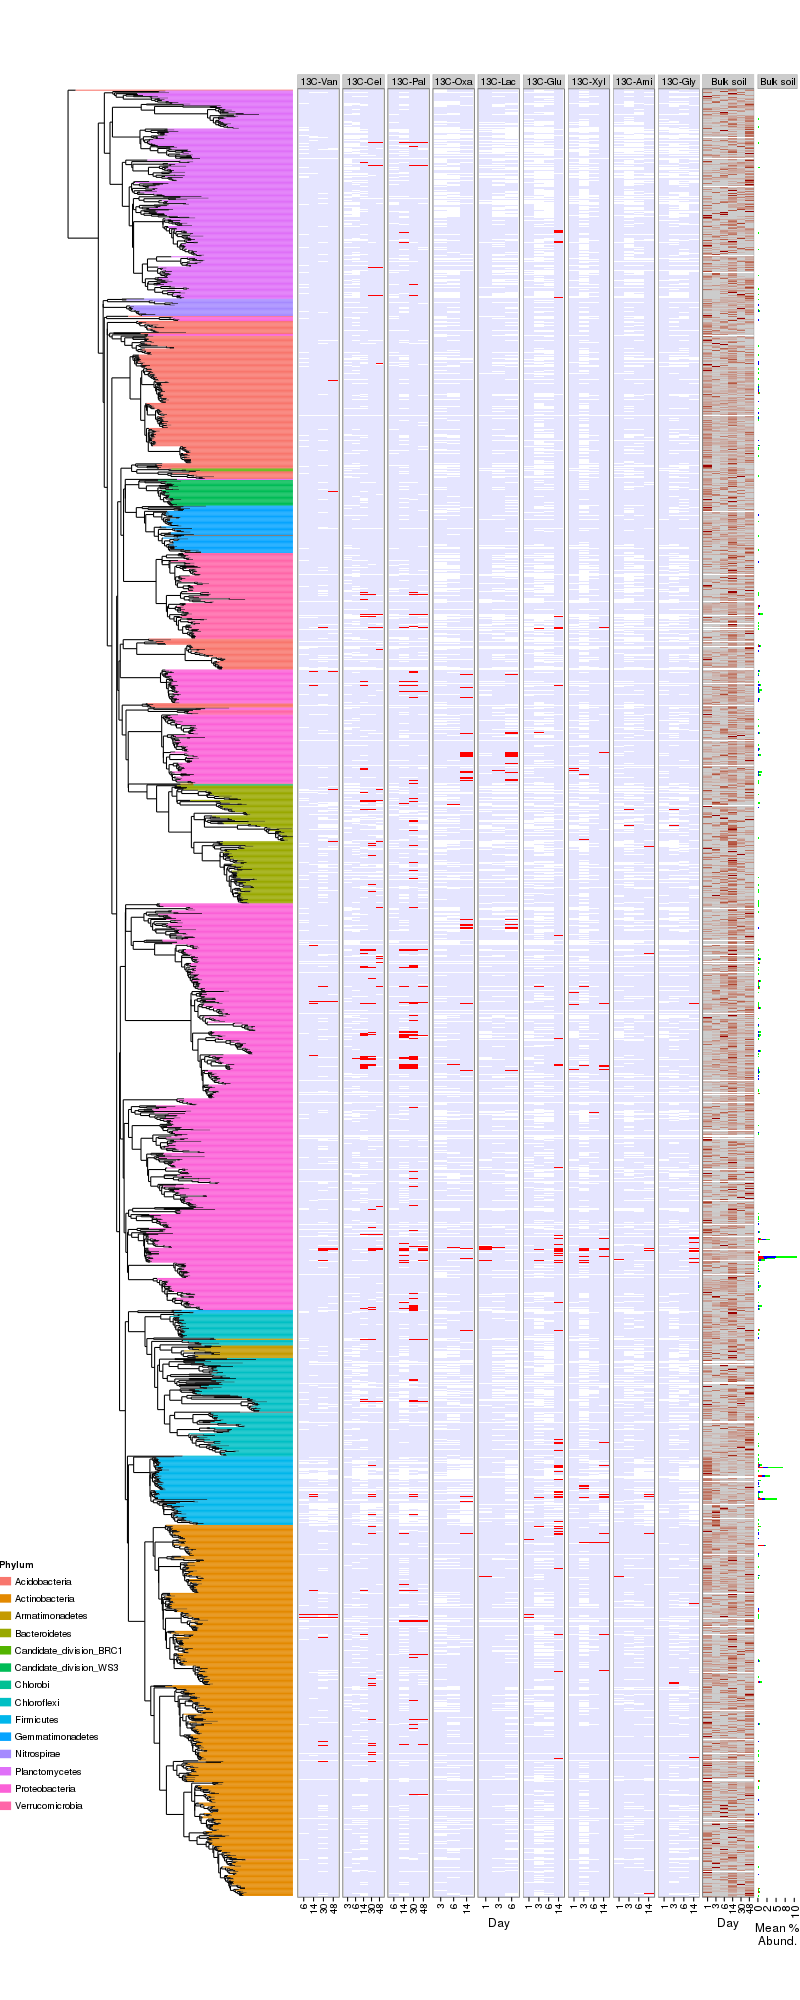

In [289]:
%%R -w 800 -h 2000
# larger size

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(2.63,0,2.45,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(2.63,0,2.45,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, plot.margin=unit(c(2.63,0.1,1.83,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [290]:
%%R -i figDir

outFile = 'allPhyla_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=2000 / 65)


p.tree = plot_tree(physeq.thresh, legend.title=' Phylum', 
                   legend.position=c(0.01,0.15), 
                   plot.margin = unit(c(-0.75,-0.2,-0.7,1.5), "cm") )
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


### Just incorporators

In [411]:
%%R
# adding incorporator status to tax_table
padj.cutoff = 0.05

physeq.thresh.inc = physeq.thresh
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) %>%
    group_by(OTU) %>%
    summarize(Incorporator = any(padj < padj.cutoff) %>% as.numeric) %>%
    ungroup() 

tax = physeq.thresh.inc %>% tax_table %>% as.data.frame
tax$OTU = rownames(tax)
tax.j = left_join(tax, df.l2fc.s, c('OTU' = 'OTU')) %>% 
    mutate(Incorporator = ifelse(is.na(Incorporator), 0, Incorporator)) %>%
    as.data.frame() 
rownames(tax.j) = tax.j$OTU %>% as.character
tax.j$OTU = NULL

physeq.thresh.inc = phyloseq(physeq.thresh.inc %>% otu_table, 
                             tax.j %>% as.matrix %>% tax_table, 
                             physeq.thresh.inc %>% sample_data,
                             physeq.thresh.inc %>% phy_tree)
physeq.thresh.inc = subset_taxa(physeq.thresh.inc, Incorporator==1)
physeq.thresh.inc

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 266 taxa and 1018 samples ]
sample_data() Sample Data:       [ 1018 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 266 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 266 tips and 265 internal nodes ]


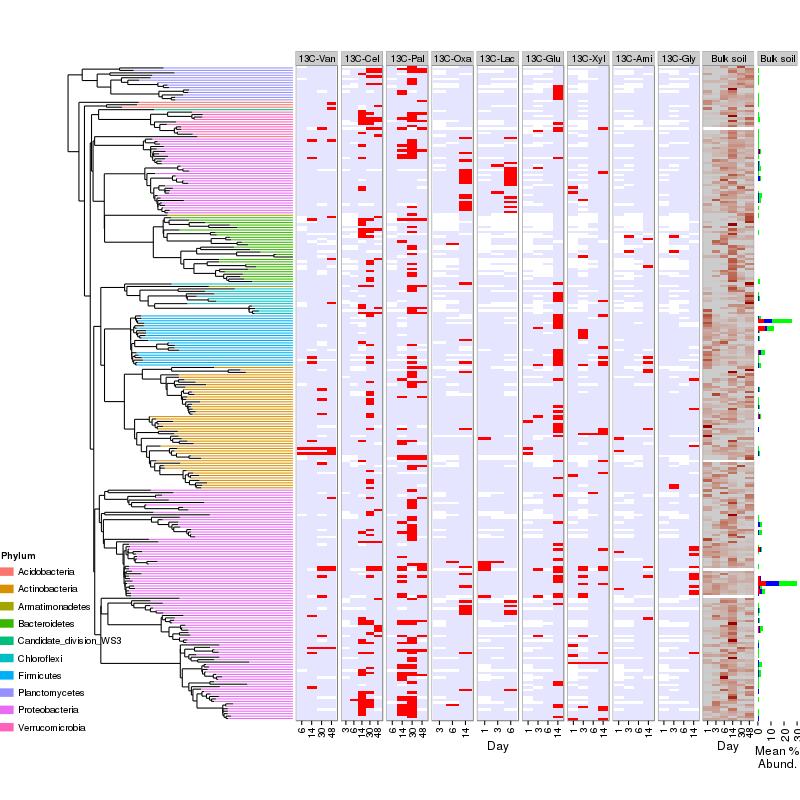

In [418]:
%%R -w 800 -h 800

# tree plot
p.tree = plot_tree(physeq.thresh.inc, legend.title=' Phylum', 
                   legend.position=c(0.01,0.15), 
                   plot.margin=unit(c(1.25,0,1.22,1.5), "cm"))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.thresh.inc, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.thresh, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.81,0,1.62,-0.8), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.81,0,1.62,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, plot.margin=unit(c(1.81,0.1,1,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [423]:
%%R -i figDir

outFile = 'allPhyla-inc_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1000 / 65)


p.tree = plot_tree(physeq.thresh.inc, legend.title=' Phylum', 
                   legend.position=c(0.01,0.15), 
                   plot.margin=unit(c(0.71,0,0.74,1.5), "cm"))
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


# Figures for each phylum

In [267]:
%%R
# ordering substrates by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Substrate %>% levels
full.tree.ord

[1] "13C-Van" "13C-Cel" "13C-Pal" "13C-Oxa" "13C-Lac" "13C-Glu" "13C-Xyl"
[8] "13C-Ami" "13C-Gly"


In [268]:
%%R
# total OTU counts for each day (for normalizing)
# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.thresh, df.l2fc.s) 

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 

# total OTU counts for bulk soils
total.counts = df.bulk %>% 
    group_by(Day) %>%
    summarize(total_count = sum(count)) %>%
    as.data.frame 

total.counts

  Day total_count
1   1       13739
2  14       16863
3   3        9043
4  30        6261
5  48       12461
6   6        9783


In [269]:
%%R
physeq.thresh.tax = physeq.thresh %>% tax_table %>% as.matrix %>% as.data.frame
physeq.thresh.tax$Rank2 %>% table %>% sort(decreasing=T)

.
         __Proteobacteria          __Actinobacteria          __Planctomycetes 
                      600                       429                       242 
          __Acidobacteria             __Chloroflexi           __Bacteroidetes 
                      222                       148                       137 
        __Verrucomicrobia              __Firmicutes        __Gemmatimonadetes 
                      104                        83                        54 
 __Candidate_division_WS3             __Nitrospirae         __Armatimonadetes 
                       30                        20                        18 
__Candidate_division_BRC1                __Chlorobi 
                        3                         1 


## Proteobacteria

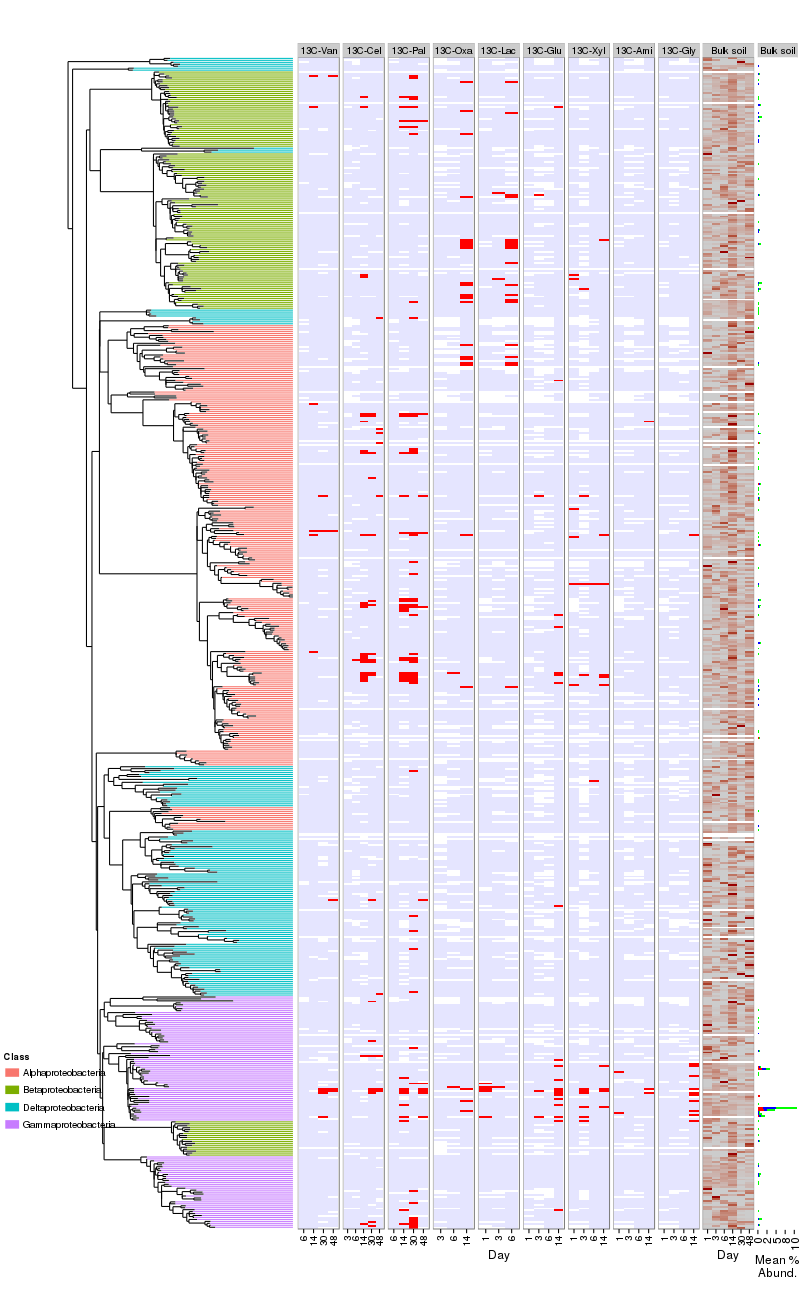

In [295]:
%%R -w 800 -h 1300

# phylum selection
phylum = "__Proteobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class')

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.52,0,1.32,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              plot.margin=unit(c(1.52,0.1,0.7,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [297]:
%%R -i figDir

outFile = 'Proteo_sparsityCut.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class', 
                   plot.margin = unit(c(-0.19,-0.2,-0.2,1.5), "cm") )
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


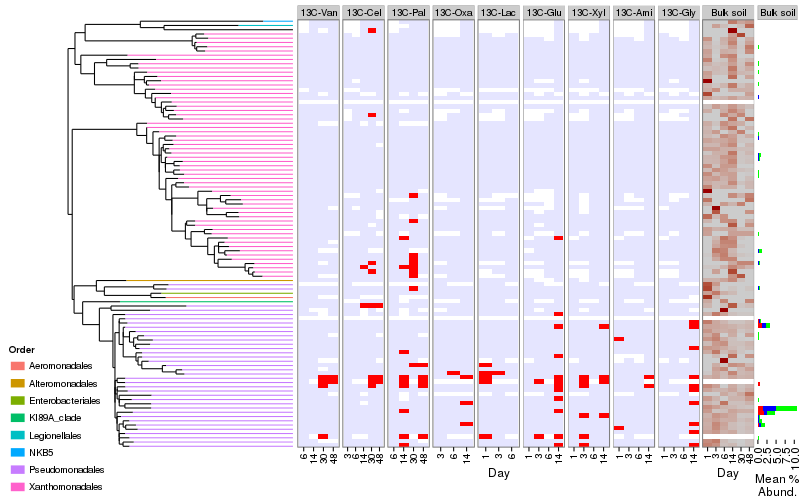

In [309]:
%%R -w 800 -h 500

# Class selection
phylum = "__Gammaproteobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   legend.position=c(0,0.1),
                   plot.margin=unit(c(0,0,0.64,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [310]:
%%R -i figDir

outFile = 'Gamma_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


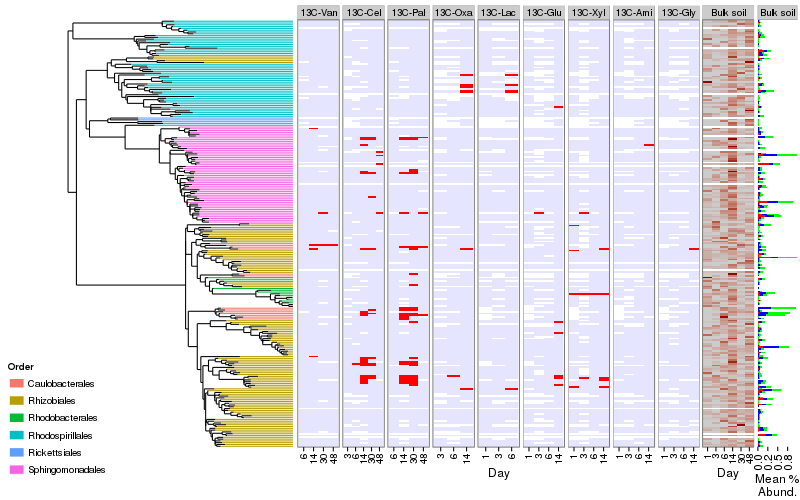

In [311]:
%%R -w 800 -h 500

# Class selection
phylum = "__Alphaproteobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   legend.position=c(0,0.1),
                   plot.margin=unit(c(0,0,0.64,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [313]:
%%R -i figDir

outFile = 'Alpha_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)

p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   legend.position=c(0,0.1),
                   plot.margin=unit(c(-0.1,0,0.64,1.5), 'cm'))
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


## Actinobacteria

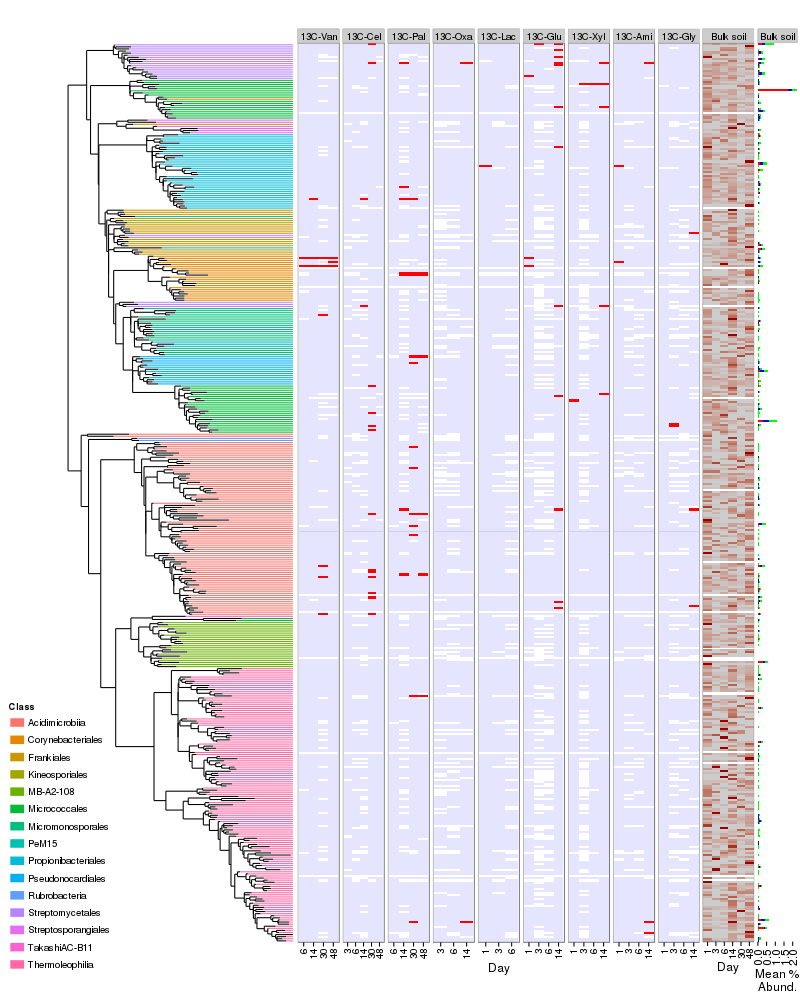

In [293]:
%%R -w 800 -h 1000

# phylum selection
phylum = "__Actinobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class')

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.02,0,0.86,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.02,0,0.88,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(1.02,0.1,0.18,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [294]:
%%R -i figDir

outFile = 'Actino_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class', 
                   plot.margin = unit(c(-0.75,-0.2,-0.7,1.5), "cm") )
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


## Planctomycetes

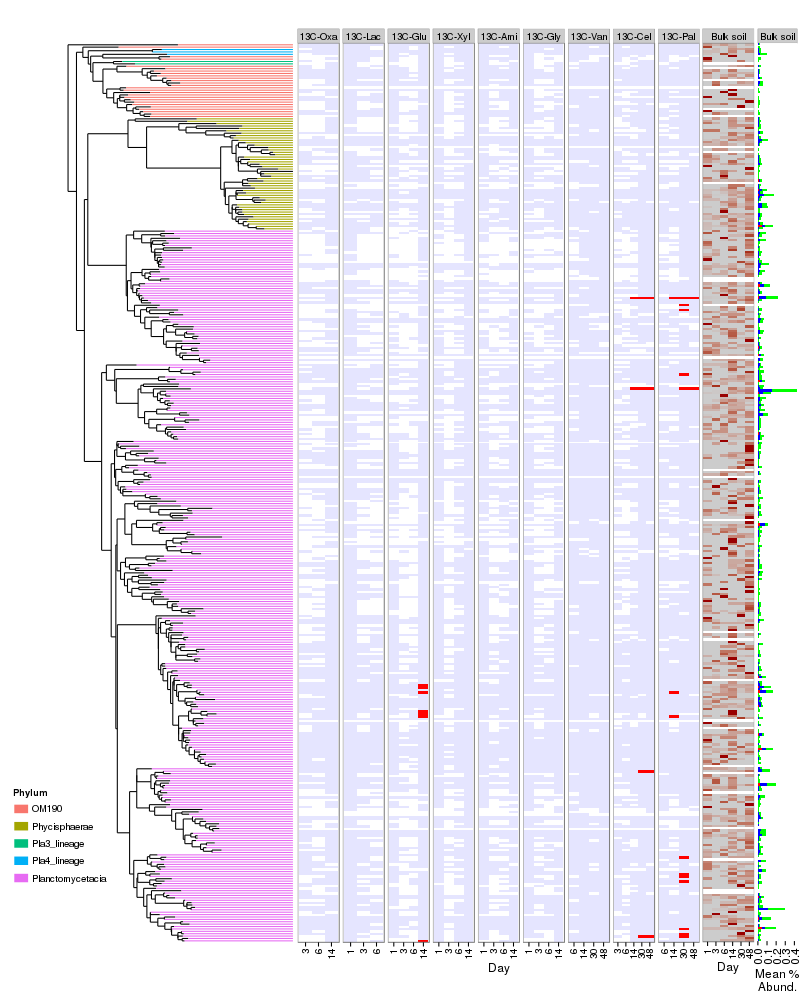

In [206]:
%%R -w 800 -h 1000

# phylum selection
phylum = "__Planctomycetes"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum, legend.title='Class')

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3')

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.02,0,0.86,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.02,0,0.88,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(1.02,0.1,0.20,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

## Acidobacteria

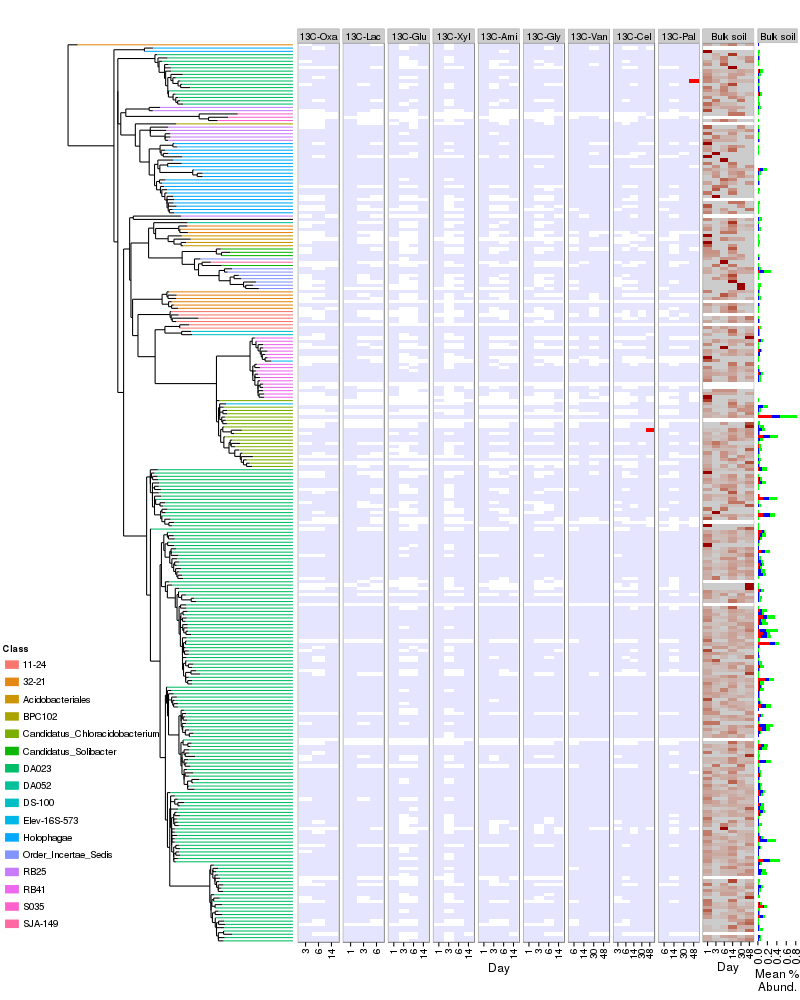

In [207]:
%%R -w 800 -h 1000

# phylum selection
phylum = "__Acidobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', 
                   legend.position=c(0.1,0.2), legend.title='Class')

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord) 
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.02,0,0.86,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.02,0,0.88,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(1.02,0.1,0.20,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

## Chloroflexi

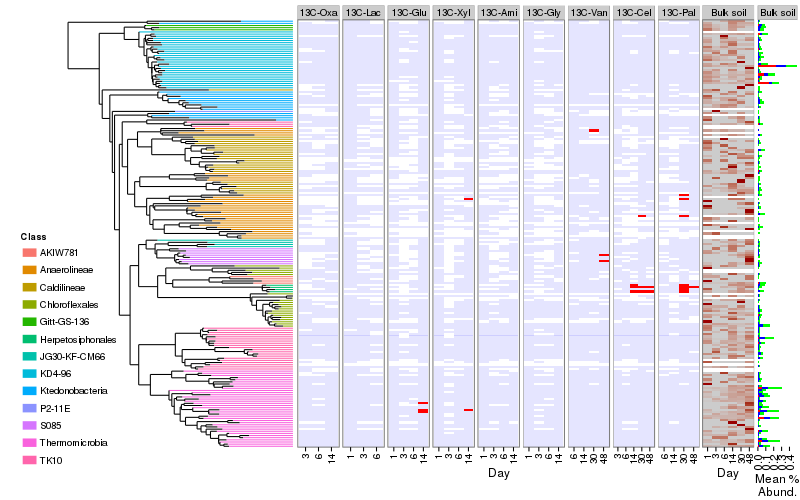

In [210]:
%%R -w 800 -h 500

# phylum selection
phylum = "__Chloroflexi"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0,0,0.64,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

## Bacteroidetes

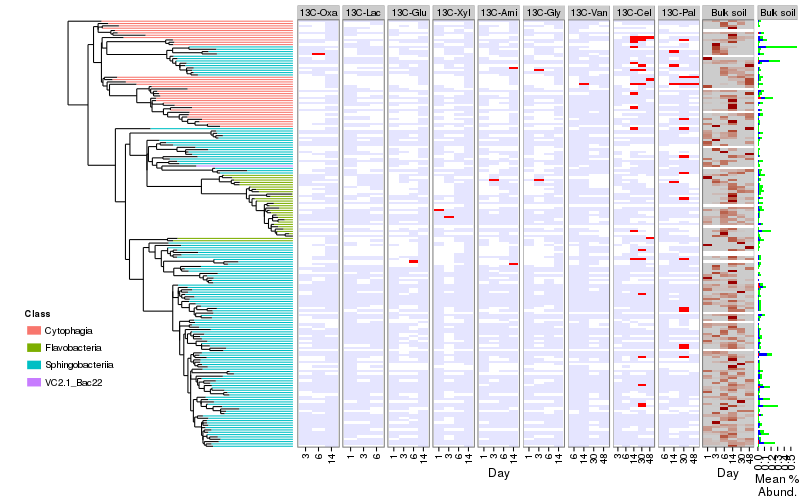

In [211]:
%%R -w 800 -h 500

# phylum selection
phylum = "__Bacteroidetes"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0,0,0.64,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

## Verrucomicrobia

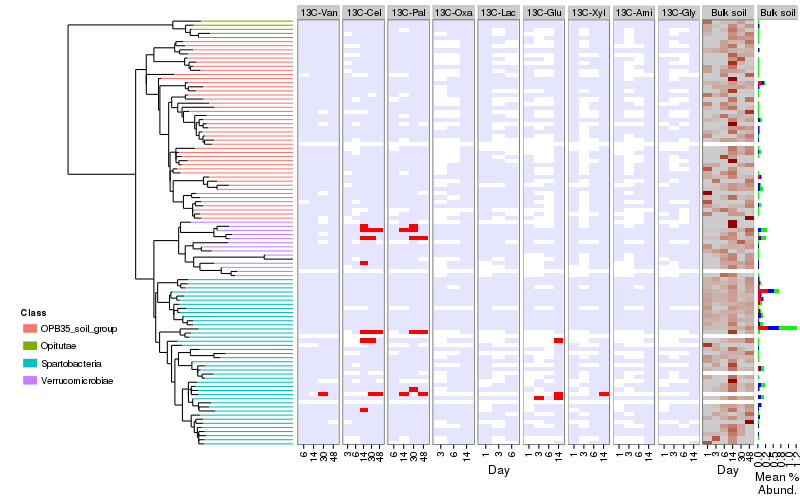

In [302]:
%%R -w 800 -h 500

# phylum selection
phylum = "__Verrucomicrobia"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0,0,0.73,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.78,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.78,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0.1,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [303]:
%%R -i figDir

outFile = 'Verruco_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


## Firmicutes 

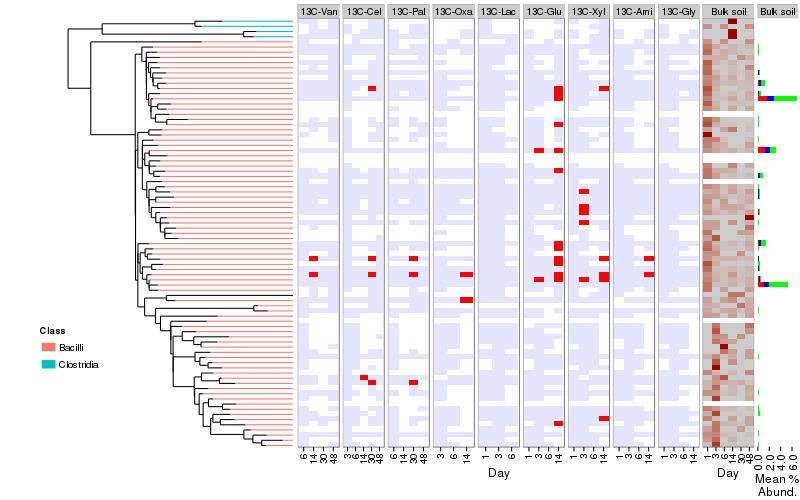

In [304]:
%%R -w 800 -h 500

# phylum selection
phylum = "__Firmicutes"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0,0,0.67,1.5), 'cm'))


# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord) 
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)


# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.15,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.15,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.15,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [305]:
%%R -i figDir

outFile = 'Firmicutes_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


## Gemmatimonadetes

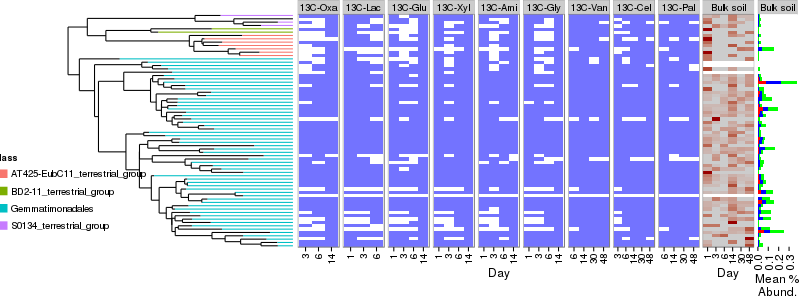

In [222]:
%%R -w 800 -h 300

# phylum selection
phylum = "__Gemmatimonadetes"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0.14,0,1,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))